<a href="https://colab.research.google.com/github/yossefPartouche/Deep_Learning/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3

## Instructions:

- All previous instructions hold.
- In addition, if you are using GPU, you must check that your code also runs on a CPU.
- **Make sure you use the best practices you learned in class**.

## Intro:

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, We learned in the reciation that we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

## In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
from torchsummary import summary
import sys
import os

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Part A (40 points)
# Convolutional Neural Network - Classifiying CIFAR-10


### Data Preprocessing

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Image shape:  torch.Size([3, 32, 32])
      frog       deer       ship      horse


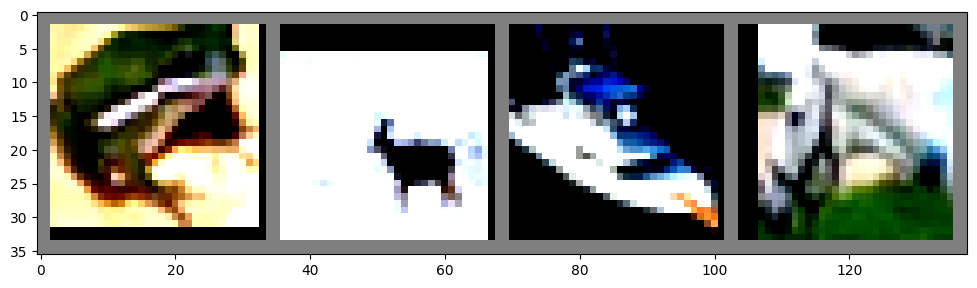

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is **NOT** allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [ ]:
from torch.nn.modules.pooling import MaxPool1d
from torch.nn.modules.activation import ReLU


class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(channels, channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(channels, channels, 3, padding=1)
    )
  def forward(self, x):
    return torch.relu(self.conv(x) + x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.features = torch.nn.Sequential(
          nn.Conv2d(3, 6, 3),
          nn.BatchNorm2d(6),
          nn.ReLU(),

          ResidualBlock(6),
          nn.Conv2d(6, 6, 3),
          nn.BatchNorm2d(6),
          nn.ReLU(),

          nn.Conv2d(6, 16, 5),
          nn.BatchNorm2d(16),
          nn.ReLU(),

          ResidualBlock(16),
          nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU()
        )
        self.classifier = nn.Sequential(
          nn.Linear(16*13*13, 120),
          nn.ReLU(),
          nn.Linear(120, 84),
          nn.ReLU(),
          nn.Linear(84,10)
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the prediction of your model.                      #
        #############################################################################
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

device = torch.device("cpu")
#net = Net().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Using device: cpu


In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
summary(model=net, input_size = images.shape[1:])

torch.Size([64, 3, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
       BatchNorm2d-2            [-1, 6, 30, 30]              12
              ReLU-3            [-1, 6, 30, 30]               0
            Conv2d-4            [-1, 6, 30, 30]             330
              ReLU-5            [-1, 6, 30, 30]               0
            Conv2d-6            [-1, 6, 30, 30]             330
     ResidualBlock-7            [-1, 6, 30, 30]               0
            Conv2d-8            [-1, 6, 28, 28]             330
       BatchNorm2d-9            [-1, 6, 28, 28]              12
             ReLU-10            [-1, 6, 28, 28]               0
           Conv2d-11           [-1, 16, 24, 24]           2,416
      BatchNorm2d-12           [-1, 16, 24, 24]              32
             ReLU-13           [-1, 16, 24, 24]               0
           

In [ ]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the       #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        #
#############################################################################
def train_model(model, train_loader, num_epochs):
  device = next(model.parameters()).device

  train_losses = []
  train_accs = []

  for epoch in range(num_epochs):

    total_loss, total_correct, total = 0.0, 0, 0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total += inputs.size(0)

    train_loss = total_loss / total
    train_acc = total_correct / total

    #------- Store History-------

    train_losses.append(train_loss)
    train_accs.append(train_acc)


    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} train_acc={train_acc:.3f} ")

  return train_losses, train_accs


# -----------------------------------------------------------------------   #
# ---------------------------train & plots-------------------------------   #
# -----------------------------------------------------------------------   #









#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################


In [ ]:
EPOCHS = 10  # You can adjust the number of epochs as needed
train_losses, train_accs = train_model(net, trainloader, EPOCHS)

Epoch 00 | train_loss=1.0382 train_acc=0.631 
Epoch 01 | train_loss=1.0104 train_acc=0.639 
Epoch 02 | train_loss=0.9857 train_acc=0.651 
Epoch 03 | train_loss=0.9677 train_acc=0.655 
Epoch 04 | train_loss=0.9489 train_acc=0.660 
Epoch 05 | train_loss=0.9317 train_acc=0.668 
Epoch 06 | train_loss=0.9178 train_acc=0.673 
Epoch 07 | train_loss=0.9011 train_acc=0.680 
Epoch 08 | train_loss=0.8924 train_acc=0.683 
Epoch 09 | train_loss=0.8756 train_acc=0.689 


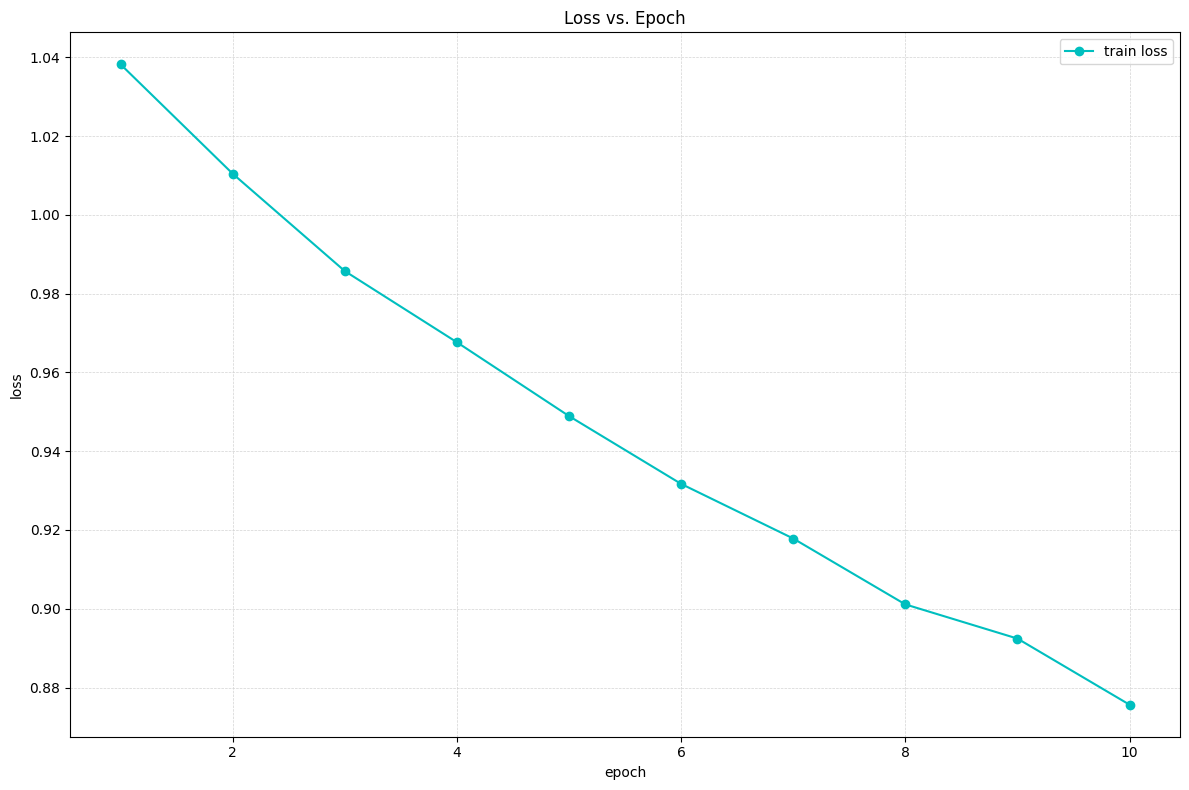

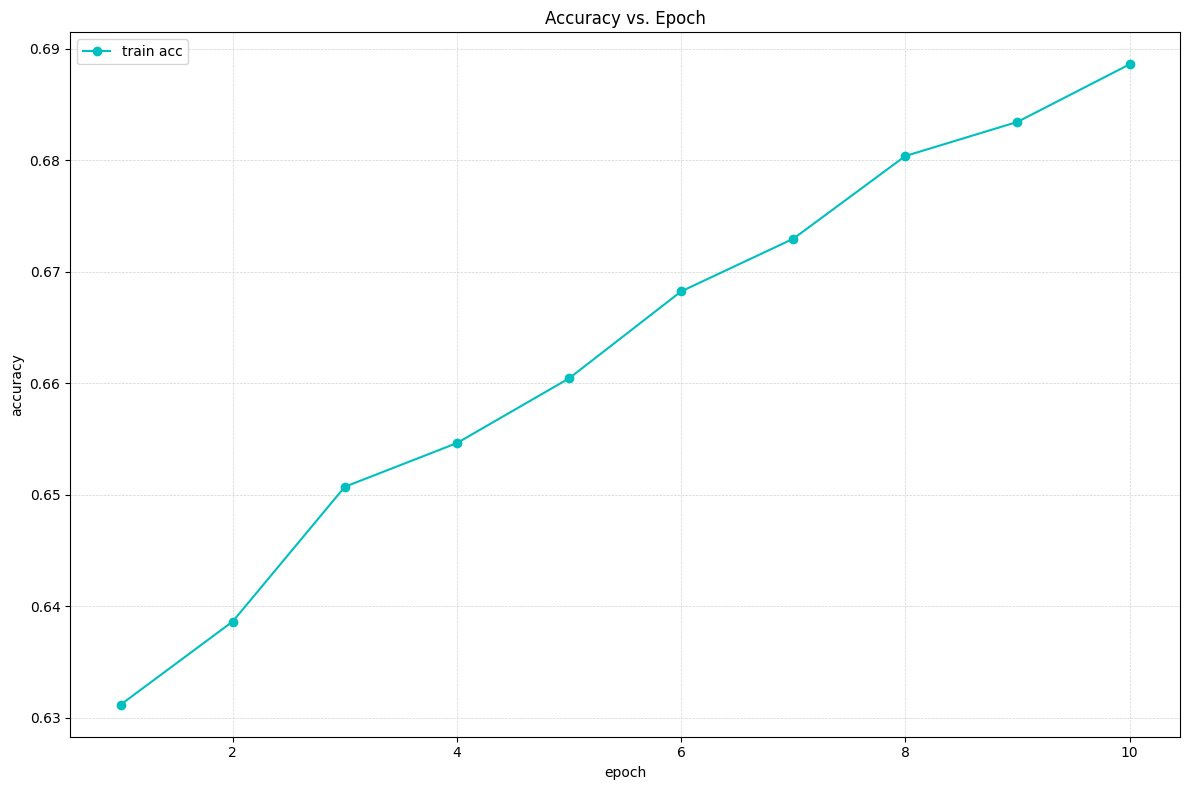

In [ ]:
epochs = range(1, EPOCHS+1)

# --- Plot 1 ---
plt.figure()
plt.plot(epochs, train_losses, marker='o', label='train loss',color='c')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.tight_layout(); plt.show()

# --- Plot 2 ---
plt.figure()
plt.plot(epochs, train_accs, marker='o', label='train acc',color='c')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()

### Explainability

$\text{ We present different methods to understand what's happening inside the Network}$

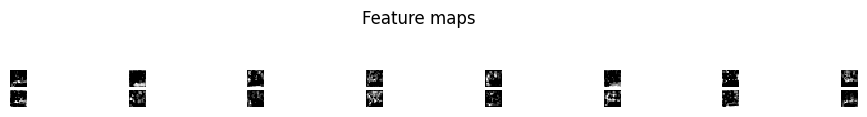

In [ ]:
images, labels = next(iter(testloader))
img = images[0:1].to(device)

with torch.no_grad():
  features = net.features(img)

  fmaps = features.squeeze(0).cpu()
  num_maps = fmaps.shape[0]
  cols = 8
  rows = (num_maps + cols -1)
  plt.figure(figsize=(12, 6))
  for i in range(num_maps):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fmaps[i], cmap='gray')
    plt.axis('off')
  plt.suptitle("Feature maps")
  plt.show()

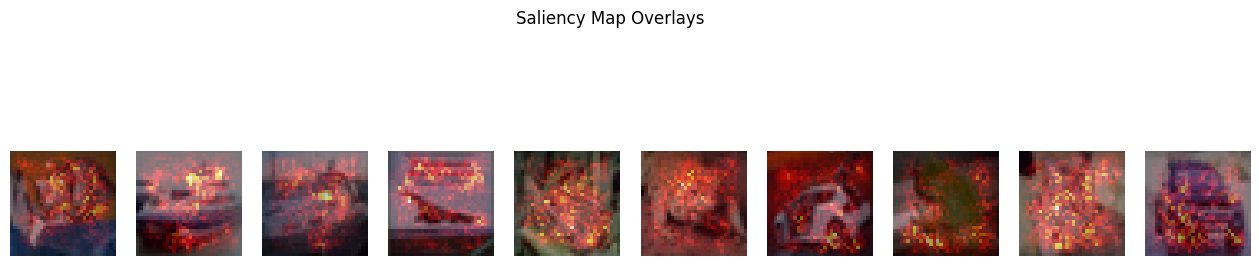

In [ ]:
net.eval()
images, labels = next(iter(testloader))
images = images.to(device)
images.requires_grad_()

outputs = net(images)
scores = outputs.gather(1, outputs.argmax(dim=1, keepdim=True))
net.zero_grad()
scores.backward(torch.ones_like(scores))

saliency_maps = images.grad.abs().max(dim=1)[0]


batch_size = 10  # how many images to show
plt.figure(figsize=(16, 4))

for i in range(batch_size):
    img_to_show = images[i].detach().cpu().permute(1, 2, 0).numpy()
    img_to_show = (img_to_show - img_to_show.min()) / (img_to_show.max() - img_to_show.min())
    saliency = saliency_maps[i].detach().cpu()

    plt.subplot(1, batch_size, i+1)
    plt.imshow(img_to_show)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
plt.suptitle("Saliency Map Overlays")
plt.show()

## Model evaluation

Calculate the model accuracy on the test set and print a confusion matrix where the Y-axis represents the real category and the X-axis represents the predicted category. (10 points)

In [ ]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0.0
total_correct = 0
total_images = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as demonstrated in the                          #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################
net.eval()
device = next(net.parameters()).device

with torch.no_grad():
    for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = net(inputs)

      preds = outputs.argmax(dim=1)

      total_correct += (preds == labels).sum().item()
      total_images += labels.size(0)

      for t, p in zip(labels.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] +=1

model_accuracy = 100.0 * total_correct / total_images

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 71.04%


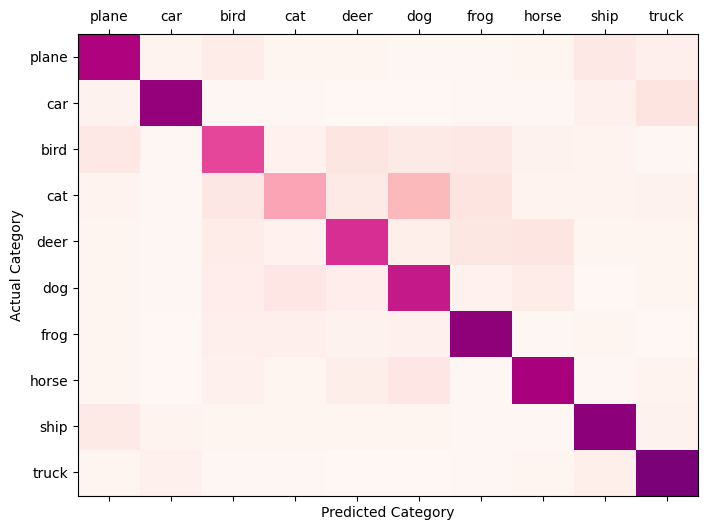

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('RdPu'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question 1:**
Describe your experiments.
- Which specific hyperparameters (e.g., LR, Batch Size) or architectural changes (e.g., number of layers, kernel sizes) did you tweak?
- Did you encounter overfitting or underfitting? How did you solve it?
- Successes vs. Failures: Describe one configuration that failed or performed poorly, and try to explain why. Then, contrast it with what worked.
- What was the single most impactful change you made that boosted your accuracy over the 60% threshold?
   **(5 Points)**

**Your answer:**






##**Question 2:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**




# Part B (60 points)
# Localization as Regression

In this next part, we will utilize a well-known architecture called ResNet18. This model has been pretrained on ImageNet, a dataset significantly larger and richer than CIFAR10, containing over 1 million images across 1,000 classes.

The Goal: We will use the features extracted by the pretrained ResNet18 to perform a dual task: classifying and localizing images of 🐈 and 🐕.

Why do this?

Using a pretrained network as a building block for new tasks—a technique known as Transfer Learning—is a cornerstone of modern Deep Learning. By leveraging the robust visual features ResNet18 has already learned (like edges, textures, and shapes), we can train a high-performing model for our specific task using a surprisingly small number of images.

## ⚠️ Prerequisite: Data Setup
Before starting Part 2, you must upload the provided data folder to your Google Drive.

1. Download the data_hw3 folder provided with this assignment.

2. Upload the entire data_hw3 folder to the root directory of your Google Drive (inside "My Drive").

3. Mount Drive: Ensure your Drive is mounted in the notebook (run the cell below).

Note: If you upload the folder inside other sub-folders, you will need to adjust the file paths in the code accordingly.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 1. Mount the entire Drive to the standard location
drive.mount('/content/drive')

# 2. Path to the folder you mounted
project_path = '/content/drive/MyDrive/Colab Notebooks/data_hw3' # change if needed

# Add it to the system path if it's not there
if project_path not in sys.path:
    sys.path.append(project_path)

# Verify what is inside the folder (needs to be ['dataloader.py', 'animals'])
print(f"Files found in {project_path}:")
try:
    print(os.listdir(project_path))
except FileNotFoundError:
    print("Error: The path does not exist. Check if the folder name is exactly 'data_hw3'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files found in /content/drive/MyDrive/Colab Notebooks/data_hw3:
['annotations.html', 'animals', '__pycache__', 'dataloader.py']


In [31]:
from dataloader import bb_intersection_over_union as calculate_iou
from dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.patches as patches
import torchvision.models as models
from PIL import Image
import collections
from torchsummary import summary
import time
import copy


## load ResNet18
To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [11]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


## Note:
ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [29]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = os.path.join(project_path,"animals")
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [13]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))
print(sample.keys())

dict_keys(['image', 'label', 'bbox'])


<Figure size 1200x800 with 0 Axes>

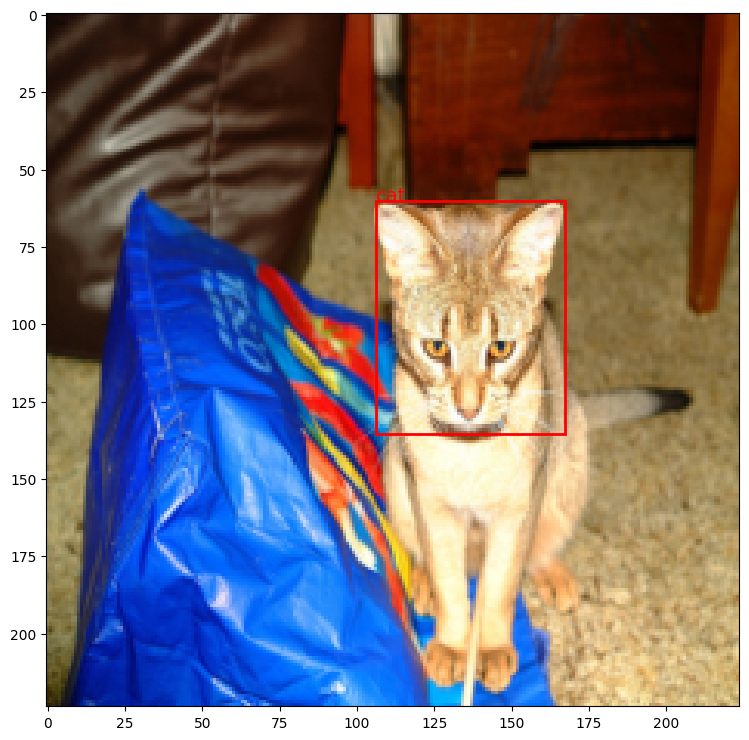

In [30]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

**(20 Points)**

In [34]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # 1. Load the pretrained ResNet-18 network.                                 #
        # 2. Remove the top fully connected layer so we could use the features of   #
        #    the network and not the only the classification layer which carries    #
        #    significantly less information.                                        #
        #                                                                           #
        # 3. Heads: Define two separate sub-networks (heads) that take the          #
        #    backbone's output features as input:                                   #
        #      a) Classification Head: features -> FC layers -> class scores        #
        #      b) Detection Head:      features -> FC layers -> Bbox coordinates    #
        #                                                                           #
        # Clarification:                                                            #
        # - You are effectively building a multi-task network with a shared         #
        #   backbone and two parallel output branches.                              #
        # - You may choose to freeze the backbone weights or train them.            #
        # - This function has no return value                                       #
        #############################################################################
        backbone = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.class_head = nn.Sequential(
            nn.Linear(512, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
            )
        self.bbox_head = nn.Sequential(
            nn.Linear(512, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84,4)
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        features = self.backbone(images)
        feature_vec = torch.flatten(features, 1)

        c_preds = self.class_head(feature_vec)
        bb_estimate = self.bbox_head(feature_vec)

        return c_preds, bb_estimate
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
net = CNN(10).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")


Using device: cuda:0


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data_hw3\dataloader.py`.
3. Do not perform a massive grid search!!
4. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
5. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

**(30 Points)**

In [39]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    # added - track metrics
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_iou': [], 'val_iou': []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                #print(sample)
                images = sample.get('image')
                labels = sample.get('label')
                bboxes = sample.get('bbox')
                images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    c_preds, bb_estimates = model(images)
                    print("bb_estimate", bb_estimates[0])
                    print("Actual Box", bboxes[0])
                    loss_cls = criterion_cls(c_preds, labels)
                    loss_bbox = criterion_bbox(bb_estimates, bboxes)
                    loss = loss_cls + 10*loss_bbox

                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(c_preds, 1)
                running_corrects += torch.sum(preds == labels).item()
                batch_size = bb_estimates.size(0)
                batch_iou = 0.0

                for i in range(batch_size):
                  batch_iou += calculate_iou(bb_estimates[i], bboxes[i])

                iou += batch_iou / batch_size
                # The above for loop can be vectorised - deal with it later




                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = torch.tensor(running_corrects, dtype=torch.float32) / dataset_sizes[phase]
            iou = iou / dataset_sizes[phase]

            # added - log metrics
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_iou'].append(iou)


            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [40]:
cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################

for param in cnn.backbone.parameters():
  param.requires_grad = False

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()

optimizer = optimizer = torch.optim.Adam(
    list(cnn.class_head.parameters()) + list(cnn.bbox_head.parameters()),
    lr=1e-3, weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
best_model,history = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


bb_estimate tensor([-0.1366,  0.1037,  0.0509, -0.0241], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual Box tensor([0.2400, 0.0030, 0.8820, 0.8408], device='cuda:0')
bb_estimate tensor([-0.0241,  0.1992,  0.2813,  0.1983], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual Box tensor([0.4920, 0.1920, 0.7940, 0.5707], device='cuda:0')
bb_estimate tensor([0.1463, 0.2058, 0.7356, 0.5707], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual Box tensor([0.2480, 0.2027, 0.7800, 0.7120], device='cuda:0')
bb_estimate tensor([0.4598, 0.2588, 1.0850, 0.8542], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual Box tensor([0.5347, 0.1533, 0.7812, 0.5167], device='cuda:0')
bb_estimate tensor([0.5640, 0.1378, 1.1150, 0.9658], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual Box tensor([0.2407, 0.1820, 0.5955, 0.5000], device='cuda:0')
bb_estimate tensor([0.4546, 0.1239, 0.7634, 0.6605], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual Box tensor([0.48

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

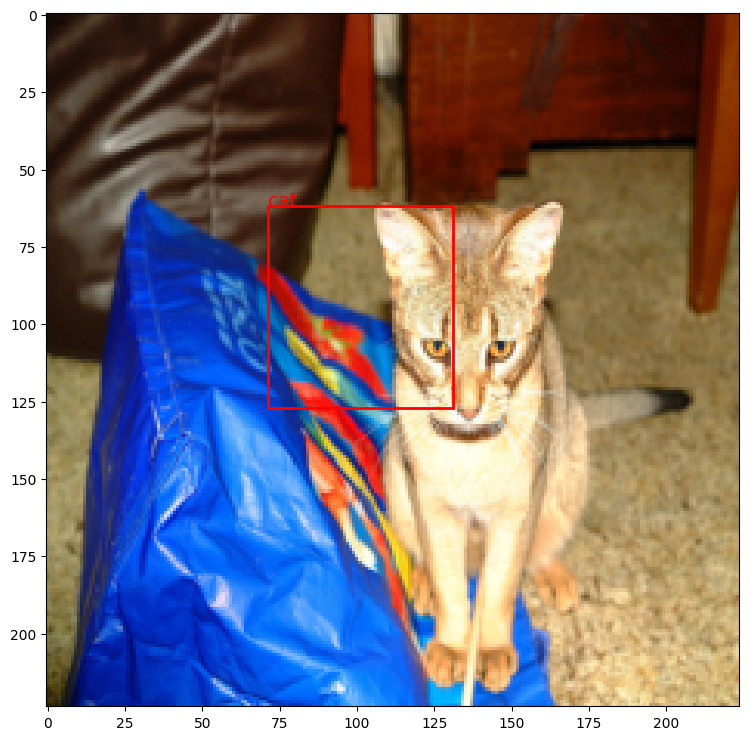

In [21]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

## visualizations

Your visualizations here:
- IoU / Accuracy / Loss on training and validation datasets as a function of the epoch).
- Only visualize the results of your best model.

**(10 Points)**

In [ ]:
def plot_metrics(history):
    """
    Visualize IoU, Accuracy, and Loss over epochs.

    Args:
        history: Dictionary containing training and validation metrics.
    """
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################















#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [ ]:
plot_metrics(history)